In [1]:
#!pip install -I rpy2==3.4.2

2023-05-26 09:58:08.053040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 09:58:08.129290: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 09:58:12.223913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


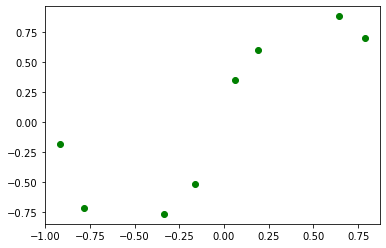

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %%
# import packages, set path and create tf session

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras import regularizers
from keras import optimizers
import keras
import matplotlib.pyplot as plt
import tensorflow
import rpy2.robjects as robjects

project_path = ""


def splineFit(x_train, y_train, lamb):
    # extract R function for cubic smoothing spline and fit it to data w.r.t.
    # the penalty parameter lamb
    # returns the fitted spline

    r_x = robjects.FloatVector(x_train)
    r_y = robjects.FloatVector(y_train)

    r_smooth_spline = robjects.r['smooth.spline'] #extract R function
    kwargs = {"x": r_x, "y": r_y, "lambda": lamb}

    return r_smooth_spline(**kwargs)


def splinePredict(spline, x):
    # evaluate the fitted cubic smoothing spline 'spline' at the data x
    # returns: function evaluations as np.array

    pred = robjects.r['predict'](spline, robjects.FloatVector(x)).rx2('y')
    return np.array(pred)

# %%
# set parameters and create data

np.random.seed(seed=6)  # set seed 3+2

d = 1  # output dimension
n_samples = 8  # number of samples



# training data
x_min = -1
x_max = 1
#x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
x_train = np.random.uniform(-1,1,8).reshape(n_samples, d)
x_train = np.sort(x_train, 0)

# xrange for plots
resolution = 1920
x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

y_min = -500.6
y_max = 500.6

# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_train = (np.random.normal(scale=1/16,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(256, d)-0.5)*2.0).reshape(256, d)
y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')


 

In [3]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(x_train,y_train)


KNeighborsRegressor(n_neighbors=1)

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
polymodel = Pipeline([('poly', PolynomialFeatures(degree=7)),
                  ('linear', LinearRegression(fit_intercept=False))])
polymodel = polymodel.fit(x_train, y_train)
linmodel = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
linmodel = linmodel.fit(x_train, y_train)

#model.named_steps['linear'].coef_
#array([ 3., -2.,  1., -1.])

60/60 [==============================] - 0s 2ms/step


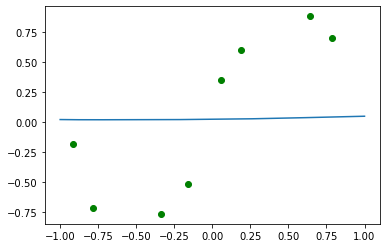

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %%
# import packages, set path and create tf session

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras import regularizers
from keras import optimizers
import keras
import matplotlib.pyplot as plt
import tensorflow
import rpy2.robjects as robjects

project_path = ""

#sess = tensorflow.InteractiveSession()
#sess.run(tensorflow.global_variables_initializer())


# %%
# define functions

def createModelTrainBothLayers(n=1024, s=0.05, l2reg=10**-5, seed=None):
    # creates an classical Shallow with n hidden nodes Ridge regularization on all parameters is controlled by l2reg.

    model = Sequential()
    model.add(Dense(n,
                    activation='relu',
                    input_dim=d,
                    trainable=True,
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myHiddenLayer"))
    model.add(Dense(1,
                    activation='linear',
                    kernel_initializer=RandomUniform(minval=-s,
                                                     maxval=s,
                                                     seed=seed),
                    bias_initializer=RandomUniform(minval=-s,
                                                   maxval=s,
                                                   seed=seed),
                    kernel_regularizer=regularizers.l2(l2reg),
                    bias_regularizer=regularizers.l2(l2reg),
                    name="myOutputLayer"))
 
    return model



# %%
# set parameters and create data

#np.random.seed(seed=3+2)  # set seed

d = 1  # output dimension
#n_samples = 16  # number of samples

# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(11)  # number of epochs
lr = 2**(-4)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'


# # training data
# x_min = -1
# x_max = 1
# x_train = np.array(np.linspace(x_min, x_max, n_samples)).reshape(n_samples, d)
# x_train = np.sort(x_train, 0)

# # xrange for plots
# resolution = 1920
# x_smooth = np.array(np.linspace(x_min, x_max, resolution)).reshape(resolution, 1)

# y_min = -500.6
# y_max = 500.6

# # training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
# y_train = (np.random.normal(scale=0,
#                             size=n_samples)+0.5)

# # validation data
# x_val = ((np.random.rand(256, d)-0.5)*2.0).reshape(256, d)
# y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
#plt.plot(x_train, y_train,'go')
#plt.plot(x_val, y_val,'k.')


# %%
# set up RSN and compile

model = createModelTrainBothLayers(n=n,l2reg=10**-10)

model.compile(optimizer="adam",#optimizers.Adam(lr=lr),
              loss='MSE',
              metrics=['MSE'])

# (plot untrained network)
plt.plot(x_smooth,model.predict(x_smooth))
plt.plot(x_train, y_train, 'go')







In [6]:
model.load_weights('NNBothTrained'+weight_name)

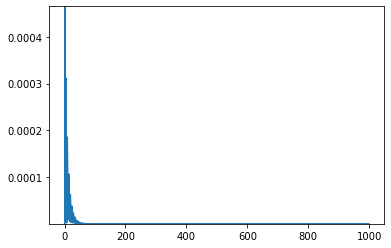

60/60 [==============================] - 0s 1ms/step


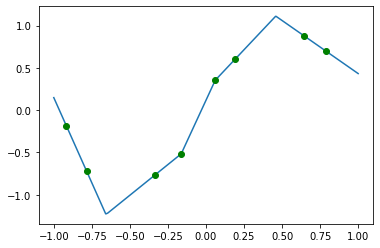

In [7]:
# train NN 
history = model.fit(x_train,
                    y_train,
                    batch_size=min(n_samples, 512),
                    epochs=1000,
                    verbose=0,
                    validation_data=(x_train, y_train),
                    shuffle=True)
# save weights in cwd
model.save_weights('NNBothTrained'+weight_name)
#w = model.get_weights() #can improof speed

# (visualize training & validation loss)
plt.plot(history.history['loss'])
#plt.ylim(bottom=0.0002900070,top=0.0002900130)
#plt.ylim(bottom=np.min(history.history['loss'],axis=None),top=0.0002900045)
plt.ylim(bottom=np.min(history.history['loss'],axis=None),top=np.max(history.history['loss'],axis=None))
#plt.plot(history.history['val_loss'])
plt.show()
plt.plot(x_smooth,model.predict(x_smooth))
plt.plot(x_train, y_train, 'go')

In [8]:
from tensorflow.keras.layers import Input, Add
from tensorflow.keras import Model

def add_if_not_None(variable_x,add_to_x):
  if variable_x is not None:
    return variable_x + add_to_x
  else:
    return None


def createModel(n=100, s=0.05, l2reg=0, seed=None, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1):
    # creates an RSN with n hidden nodes with first-layer parameters
    # sampled from Unif[-s, s] and terminal-layer parameters initialized
    # to zero. Ridge regularization on all parameters is controlled by l2reg.
    if not(use_final_bias) and linear_skip:
      print("Are you sure you want the linear skip connection but no intercept? This is a very unusual combnation.")

    l_in = Input(shape=(din, ), name='input')
    l=Dense(n,
            activation='relu',
            input_dim=din,
            trainable=False,
            kernel_initializer=RandomUniform(minval=-s,
                                              maxval=s,
                                              seed=seed),
            bias_initializer=RandomUniform(minval=-s,
                                            maxval=s,
                                            seed=add_if_not_None(seed,1)),
            kernel_regularizer=regularizers.l2(l2reg),
            bias_regularizer=regularizers.l2(l2reg),
            name="myHiddenLayer")(l_in)
    l=Dense(1,
            activation='linear',
            kernel_initializer=keras.initializers.Zeros(),
            bias_initializer=keras.initializers.Zeros(),
            kernel_regularizer=regularizers.l2(l2reg),
            bias_regularizer=regularizers.l2(l2reg_factor_affine_weights*l2reg),
            name="myOutputLayer",
            use_bias=use_final_bias)(l)
    if linear_skip:
      l_linearSkip = Dense(1,
                          activation='linear',
                          input_dim=din,
                          trainable=True,
                          kernel_initializer=keras.initializers.Zeros(),
                          use_bias=False,
                          kernel_regularizer=regularizers.l2(l2reg_factor_affine_weights*l2reg),
                          name="myLinearSkipLayer")(l_in)
      l=Add()([l,l_linearSkip])
 
    return Model(inputs=[l_in], outputs=l)

def train_model(model,lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name):
  model.compile(optimizer=optimizers.SGD(learning_rate=lr),
                loss='MSE',
                metrics=['MSE'])

  # (plot untrained network)
  #plt.plot(x_smooth,model.predict(x_smooth))
  #plt.plot(x_train, y_train, 'go')

  # %%
  # train RSN 
  history = model.fit(x_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epoch_nr,
                      verbose=verbose,
                      validation_data=validation_data,
                      shuffle=shuffle)
  # save weights in cwd
  model.save_weights('RSN'+weight_name)
  #w = model.get_weights() #can improof speed

  # (visualize training & validation loss)
  plt.plot(history.history['loss'])
  plt.yscale('log')
  plt.ylim(bottom=np.min(history.history['loss'])*0.99995,top=min(np.max(history.history['loss']),max(history.history['loss'][0],history.history['loss'][-1])*1.001))
  plt.show()
  #plt.plot(history.history['val_loss'])
  return model


def train_modelRidge(modelRidge,lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                new_version=True):
  if not(new_version):
    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr*2),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(128,epoch_nr/4)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)
    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(256,epoch_nr/2)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)

    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

    # modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr/2),
    #              loss='MSE',
    #              metrics=['MSE'])
    # # %%
    # # train ridge regularized RSN
    # historyRidge = modelRidge.fit(x_train,
    #                               y_train,
    #                               batch_size=min(n_samples, 512),
    #                               epochs=int(epoch_nr), #2**15
    #                               verbose=0,
    #                               validation_data=(x_train, y_train),
    #                               shuffle=True)
    #
    # plt.plot(historyRidge.history['loss'])
    # plt.yscale('log')
    # plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    # plt.show()
    # print(historyRidge.history['loss'][-1])

    modelRidge.compile(optimizer=optimizers.Adam(learning_rate=lr/32),
                loss='MSE',
                metrics=['MSE'])
    # %%
    # train ridge regularized RSN
    historyRidge = modelRidge.fit(x_train,
                                  y_train,
                                  batch_size=batch_size,
                                  epochs=int(max(128,epoch_nr/4)), #2**15
                                  verbose=verbose,
                                  validation_data=validation_data,
                                  shuffle=shuffle)

    plt.plot(historyRidge.history['loss'])
    plt.yscale('log')
    plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
    plt.show()
    print(historyRidge.history['loss'][-1])

  modelRidge.compile(optimizer=optimizers.SGD(learning_rate=lr/2,momentum=0.5),
              loss='MSE',
              metrics=['MSE'])

  # %%
  # train ridge regularized RSN
  historyRidge = modelRidge.fit(x_train,
                                y_train,
                                batch_size=batch_size,
                                epochs=int(min(1024,max(128,epoch_nr/4))), #2**15
                                verbose=verbose,
                                validation_data=validation_data,
                                shuffle=shuffle)

  plt.plot(historyRidge.history['loss'])
  #plt.yscale('log')
  #plt.ylim(bottom=np.min(historyRidge.history['loss'])*0.99995,top=min(np.max(historyRidge.history['loss']),max(historyRidge.history['loss'][0],historyRidge.history['loss'][-1])*1.001))
  plt.show()
  print("historyRidge.history['loss'][-1]:", historyRidge.history['loss'][-1])

  # save weights in cwd
  modelRidge.save_weights('RidgeRSN'+weight_name)
  return modelRidge

def ridgeRegLastLayer(modelRidge, x_train, y_train, l2reg, tol=0.000001, verbose=1, l2reg_factor_affine_weights=1):
  layer_names=[layer.name for layer in modelRidge.layers]
  n=modelRidge.get_layer("myHiddenLayer").units
  if l2reg_factor_affine_weights<2**(-40):
    print("l2reg_factor_affine_weights is streated as 2**(-40) for numerical stability. YOu should consider taking a larger valuefor more numerical stability.")
  rescale_affine_weights=1/np.sqrt(max(2**(-40),l2reg_factor_affine_weights))
  intermediate_output = tensorflow.keras.Model(modelRidge.input, 
                                      modelRidge.get_layer('myHiddenLayer').output)
  X_matrix=intermediate_output(x_train).numpy()
  if verbose:
    print(X_matrix.shape)
    print("x_train:")
    print(x_train.shape)
    print("rescale_affine_weights: ",rescale_affine_weights)
  additional_dimensions=0
  if "myLinearSkipLayer" in layer_names:
    X_matrix=np.concatenate((X_matrix,rescale_affine_weights*x_train),axis=1)
    additional_dimensions+=1
  if modelRidge.get_layer(name="myOutputLayer").use_bias:
    X_matrix=np.concatenate((X_matrix,rescale_affine_weights*np.ones((n_samples,1))),axis=1)
    additional_dimensions+=1
  from sklearn.linear_model import Ridge
  clf = Ridge(alpha=l2reg*n_samples,fit_intercept=False, tol=tol)
  clf.fit(X_matrix, y_train)
  # import copy
  # modelRidge2=copy.deepcopy(modelRidge)
  if modelRidge.get_layer(name="myOutputLayer").use_bias:
    #print(modelRidge.layers[1].name)
    modelRidge.get_layer(name="myOutputLayer").set_weights([clf.coef_[:n].reshape(-1,1),rescale_affine_weights*clf.coef_[-1].reshape(1,)])
  else:
    modelRidge.get_layer(name="myOutputLayer").set_weights([clf.coef_[:n].reshape(-1,1)])
  if "myLinearSkipLayer" in layer_names:
    modelRidge.get_layer(name="myLinearSkipLayer").set_weights([rescale_affine_weights*clf.coef_[n:(n+1)].reshape(-1,1)])
  print("Ridge regression claculated successfull")
  return modelRidge

def train_both_models(lr=0.1,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=1,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=100, s=0.05, seed=None, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1
                ):
  model = createModel(n=n, l2reg=0, seed=seed, use_final_bias=use_final_bias, linear_skip=linear_skip,din=din, l2reg_factor_affine_weights=l2reg_factor_affine_weights)
  tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
  train_model(model,lr=lr,x_train=x_train,
                  y_train=y_train,
                  batch_size=batch_size,
                  epoch_nr=epoch_nr,
                  verbose=verbose,
                  validation_data=validation_data,
                  shuffle=shuffle,
                  weight_name=weight_name)

  # %%
  # set up ridge regularized RSN using eq. (6) in the paper for lambda_tilda

  sSVD = n_samples/(2*tr_time) #(singular value of XTX) = (singular value of X)^2
  lambda_tilda = sSVD/(np.exp(2*sSVD*tr_time/n_samples)-1)/n_samples
  if y_train.size != n_samples:
    print("Warning: y_train.size != n_samples")
    print("y_train.size: ", y_train.size )
    print("n_samples: ", n_samples )
  print("tr_time:",tr_time,", tr_time_paper:",tr_time/n_samples)
  print("lambda_tilde:",lambda_tilda,", lambda_tilde_paper:",lambda_tilda*n_samples,", lambda_tilde equivalent formula:",1/(2*(np.exp(1)-1)*tr_time),", lambda_tilde_paper equivalent formula:",1/(2*(np.exp(1)-1)*(tr_time/n_samples)))
  #lambda_tilda = 1/tr_time #Achtung Falsch!!!

  #modelRidge = createModel(n=n, l2reg=lambda_tilda, use_final_bias=model.layers[1].use_bias) 
  modelRidge = createModel(n=n, l2reg=lambda_tilda, seed=seed, use_final_bias=use_final_bias, linear_skip=linear_skip,din=din, l2reg_factor_affine_weights=l2reg_factor_affine_weights)

  #modelRidge.set_weights(w) #can improof speed
  modelRidge.set_weights(model.get_weights())

  modelRidge=ridgeRegLastLayer(modelRidge, x_train, y_train, l2reg=lambda_tilda, tol=0.000000000000001, l2reg_factor_affine_weights=l2reg_factor_affine_weights)  

  train_modelRidge(modelRidge,lr=lr,x_train=x_train,
                  y_train=y_train,
                  batch_size=batch_size,
                  epoch_nr=epoch_nr,
                  verbose=verbose,
                  validation_data=validation_data,
                  shuffle=shuffle,
                  weight_name=weight_name)
  
  return model,modelRidge,lambda_tilda

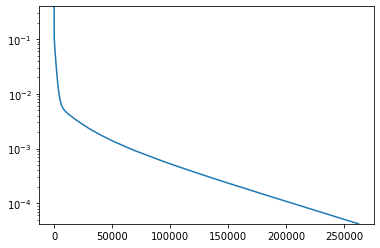

tr_time: 131072.0 , tr_time_paper: 16384.0
lambda_tilde: 2.2200649523518618e-06 , lambda_tilde_paper: 1.7760519618814894e-05 , lambda_tilde equivalent formula: 2.2200649523518618e-06 , lambda_tilde_paper equivalent formula: 1.7760519618814894e-05
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


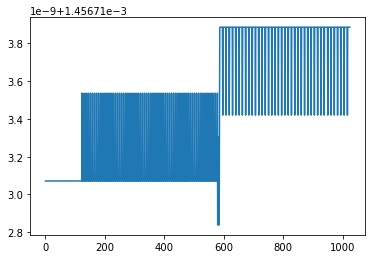

historyRidge.history['loss'][-1]: 0.001456713886000216


In [9]:
tensorflow.random.set_seed(1)
# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(18)  # number of epochs
lr = 2**(-1)#2**(-2)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'

#model = createModel(n=n, l2reg=0, use_final_bias=False, linear_skip=False)

(modelRand,modelRidgeRand,lambda_tilda) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_train,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1)

g(0)= 0.00015625000000000003
lambda_paper: 5.550162380879653e-05


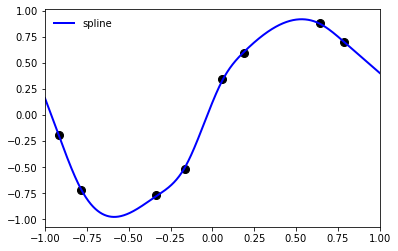

In [10]:
# %%
# fit spline regression with g(0) and regularizing parameter lambda (lamb)
# as in the paper including an adjustment for the scaling of lamb
# (see https://stats.stackexchange.com/a/430482/261315)
g_Zero = s**2/8/2 
print('g(0)=', g_Zero)
lamb = float((n_samples*lambda_tilda/(2*g_Zero)/n)/(max(x_train)-min(x_train))**3)
lambda_tilda_paper=n_samples*lambda_tilda
lambda_paper=lambda_tilda_paper/(2*g_Zero*n)
print("lambda_paper:", lambda_paper)

spline = splineFit(x_train, y_train, lamb)


# %%
# visualize result

radPlot = 1
xPlot = np.linspace(-radPlot, radPlot, 1920)
ySpline = splinePredict(spline, xPlot)
# yminPlot = min(np.min(model.predict(xPlot)),
#                np.min(modelRidge.predict(xPlot)))-0.05
# ymaxPlot = max(np.max(model.predict(xPlot)),
#                np.max(modelRidge.predict(xPlot)))+0.05

plt.plot(x_train, y_train, 'ko', markersize=8) 
#plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
#plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=3,
#        color=(1, 5/8, 0.0), label='ridge RSN')
plt.plot(xPlot, ySpline, 'b-', linewidth=2, label='spline')

#plt.ylim(-1.125, 1.125)
plt.xlim(-radPlot, radPlot)

plt.legend(loc='upper left', frameon=False) 

60/60 [==============================] - 0s 2ms/step


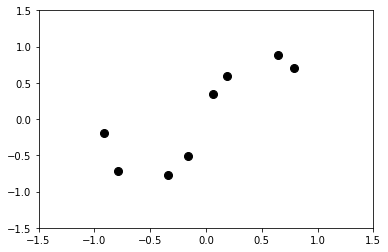

60/60 [==============================] - 0s 2ms/step


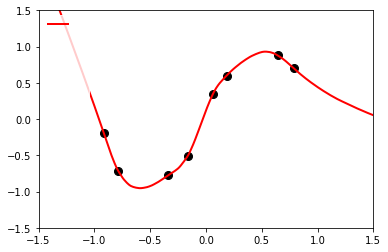

60/60 [==============================] - 0s 2ms/step


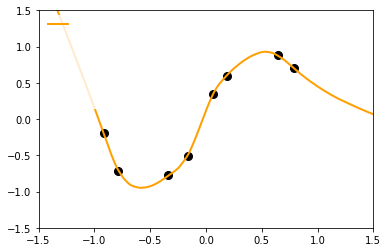

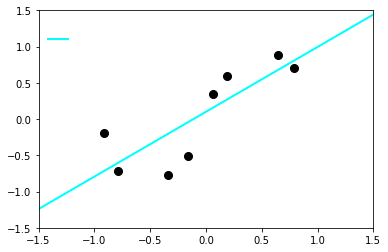

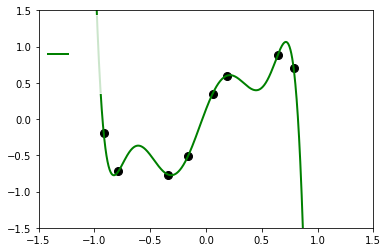

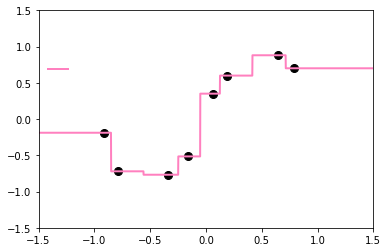

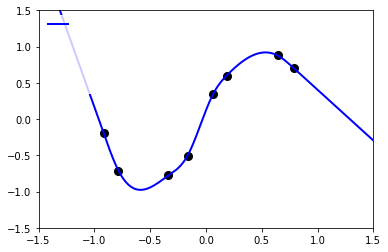

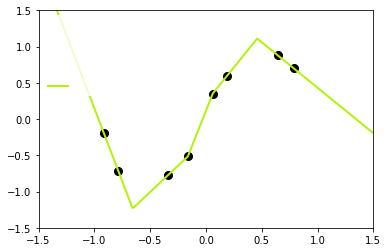

60/60 [==============================] - 0s 1ms/step


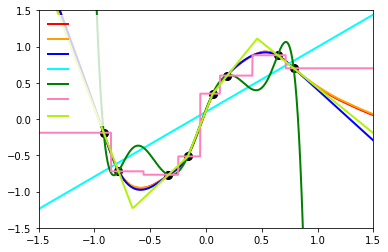

In [11]:
radPlot=1.5
xPlot=np.linspace(-radPlot,radPlot,1920)
y_lin=linmodel.predict(xPlot.reshape(-1, 1))
ySpline = splinePredict(spline, xPlot)
y_neigh=neigh.predict(xPlot.reshape(-1, 1))
y_poly=polymodel.predict(xPlot.reshape(-1, 1))
y_NN=model.predict(xPlot.reshape(-1, 1))
yminPlot=-1.5 #+0*( min(np.min(model.predict(xPlot)),np.min(modelRidge.predict(xPlot)))-0.05 )
ymaxPlot=1.5 #+ 0*( max(np.max(model.predict(xPlot)),np.max(modelRidge.predict(xPlot)))+0.05 )
choosePlot='spline'

for choosePlot in ['none','RSN', 'RSNridge', 'lin','poly','near','spline','NN','all']:

  #plt.plot(x_train,y_train,'k--',linewidth=1/8)
  plt.plot(x_train,y_train,'ko',markersize=8)#,label=r'$\left(x_i,y_i \right)$')  # $\left(x_i,y_i \right)$')

  if choosePlot=='RSN' or choosePlot=='all': 
    plt.plot(xPlot,modelRand.predict(xPlot),'r-',linewidth=2,label=r'  ')  # $\mathcal{NN}_{\theta^T}$ (implicit)')
  if choosePlot=='RSNridge' or choosePlot=='all': 
    plt.plot(xPlot,modelRidgeRand.predict(xPlot),'-',linewidth=2, color=(1, 5/8, 0.0),label=r'      ')  # $\mathcal{NN}_{\theta_{\tilde{\lambda}}}$ (Ridge)')
  #plotFromWeights('modelRidge2097152.h5','/content/modelRidge2097152.h5',T=1024)
  if choosePlot=='spline' or choosePlot=='all':
    #plt.plot(xPlot,ySpline,'-',linewidth=2,label=r'spline', alpha=1.0)  # $f^\lambda$ (spline)')
    plt.plot(xPlot,ySpline,'b-', linewidth=2,label=r'smoothing spline', alpha=1.0)  # $f^\lambda$ (spline)')
  else:
    plt.plot(xPlot,ySpline,'b-',linewidth=2,label=r'   ', alpha=0.0)  # $f^\lambda$ (spline)')  
  if choosePlot=='lin' or choosePlot=='all':  
    plt.plot(xPlot,y_lin,'-',color=(0.0, 1.0, 1.0),linewidth=2,label=r'linear')
  else:
    plt.plot(xPlot,y_lin,'-',color=(0.0, 1.0, 1.0),linewidth=2,label=r'  ', alpha=0)
  if choosePlot=='poly' or choosePlot=='all':
    plt.plot(xPlot,y_poly,'g-',linewidth=2,label=r'polynomial') 
  else:
    plt.plot(xPlot,y_poly,'g-',linewidth=2,label=r'   ', alpha=0.0)
  if choosePlot=='near' or choosePlot=='all':
    plt.plot(xPlot,y_neigh,'-',color=(1.0, 0.5, 0.75),linewidth=2,label=r'nearest neighbor')
  else:
    plt.plot(xPlot,y_neigh,'-',color=(1.0, 0.5, 0.75),linewidth=2,label=r'   ', alpha=0)
  #new:
  if choosePlot=='NN' or choosePlot=='all':
    plt.plot(xPlot,y_NN,'-', color=(0.7, 0.95, 0.05), linewidth=2,label=r'$\mathcal{NN}$') 
  else:
    plt.plot(xPlot,y_NN,'-', color=(1.0, 0.5, 0.75), linewidth=2,label=r'   ', alpha=0.0) 

  plt.ylim(yminPlot,ymaxPlot)
  plt.xlim(-radPlot,radPlot)

  legend=plt.legend(loc='upper left', frameon=True, framealpha=0.8, edgecolor='1.0')  #, bbox_to_anchor=(0.79, 0.8))
  plt.setp(legend.get_texts(), alpha=0.0)
  plt.savefig('DifferentModels_'+choosePlot+'.svg', format='svg',transparent=True)
  plt.savefig('DifferentModels_'+choosePlot+'.pdf', format='pdf',transparent=True)
  plt.show()

In [12]:
#break

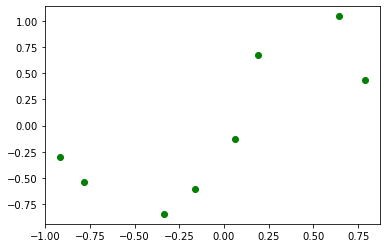

In [13]:
np.random.seed(seed=6)  # set seed 3+2


# training output #HERE YOU CAN CHANGE THE y-DATA BY REPLACING np.sin
y_trainNoise = (np.random.normal(scale=1/8,
                            size=n_samples)+np.sin(np.pi*x_train[:, 0]))

# validation data
x_val = ((np.random.rand(16, d)-0.5)*2.0).reshape(16, d)
y_val = np.sin(np.pi*x_val[:, 0])

# plot training (and validation data)
plt.plot(x_train, y_trainNoise,'go')
#plt.plot(x_val, y_val,'k.')

In [14]:
from sklearn.neighbors import KNeighborsRegressor
neighReg = KNeighborsRegressor(n_neighbors=2)
neighReg.fit(x_train,y_trainNoise)

KNeighborsRegressor(n_neighbors=2)

In [15]:
polymodelReg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])
polymodelReg = polymodelReg.fit(x_train, y_trainNoise)
linmodelReg = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
linmodelReg = linmodelReg.fit(x_train, y_trainNoise)

60/60 [==============================] - 0s 1ms/step


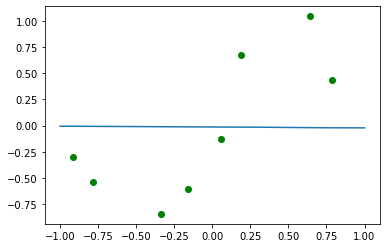

In [16]:
# training parameter
epoch_nr = 2**(12)  # number of epochs
lr = 2**(-4)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'

modelReg = createModelTrainBothLayers(n=n,l2reg=2*10**-3)#3*10**-3

modelReg.compile(optimizer="adam",#optimizers.Adam(lr=lr),
              loss='MSE',
              metrics=['MSE'])

# (plot untrained network)
plt.plot(x_smooth,modelReg.predict(x_smooth))
plt.plot(x_train, y_trainNoise, 'go')

In [17]:
2*10**-3/8

0.00025

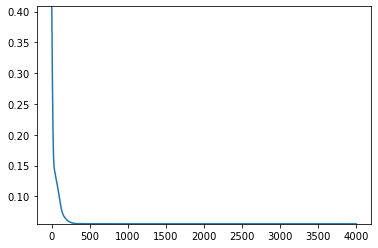

60/60 [==============================] - 0s 2ms/step


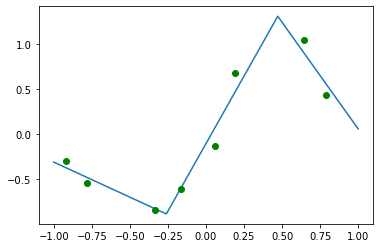

In [18]:
# train NN 
historyReg = modelReg.fit(x_train,
                    y_trainNoise,
                    batch_size=min(n_samples, 512),
                    epochs=4000,
                    verbose=0,
                    validation_data=(x_train, y_trainNoise),
                    shuffle=True)
# save weights in cwd
modelReg.save_weights('RegNNBothTrained'+weight_name)
#w = modelReg.get_weights() #can improof speed

# (visualize training & validation loss)
plt.plot(historyReg.history['loss'])
#plt.ylim(bottom=0.0002900070,top=0.0002900130)
#plt.ylim(bottom=np.min(history.history['loss'],axis=None),top=0.0002900045)
plt.ylim(bottom=np.min(historyReg.history['loss'],axis=None),top=np.max(historyReg.history['loss'],axis=None))
#plt.plot(historyReg.history['val_loss'])
plt.show()
plt.plot(x_smooth,modelReg.predict(x_smooth))
plt.plot(x_train, y_trainNoise, 'go')

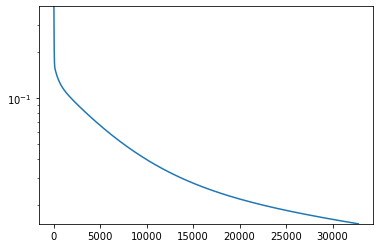

tr_time: 4096.0 , tr_time_paper: 512.0
lambda_tilde: 7.104207847525958e-05 , lambda_tilde_paper: 0.0005683366278020766 , lambda_tilde equivalent formula: 7.104207847525958e-05 , lambda_tilde_paper equivalent formula: 0.0005683366278020766
(8, 1024)
x_train:
(8, 1)
rescale_affine_weights:  1.0
Ridge regression claculated successfull


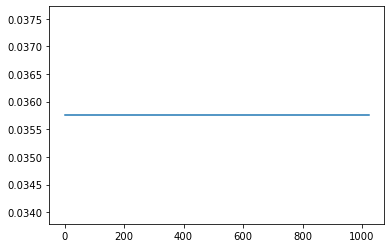

historyRidge.history['loss'][-1]: 0.03575662150979042


In [19]:
tensorflow.random.set_seed(1)
# RSN parameter
s = 0.05  # range of random initialization
n = 1024  # number of hidden nodes

# training parameter
epoch_nr = 2**(15)  # number of epochs
lr = 2**(-3)#2**(-2)  # learning rate
tr_time = epoch_nr*lr  # training time  (tr_time*n_samples = T_paper)
weight_name = 'Reg'+str(epoch_nr)+'_logT'+str(int(math.log(tr_time, 2)))+'.h5'

#model = createModel(n=n, l2reg=0, use_final_bias=False, linear_skip=False)

(modelRandReg,modelRidgeRandReg,lambda_tildaReg) = train_both_models(lr=lr,
                x_train=x_train,
                y_train=y_trainNoise,
                batch_size=min(n_samples, 512),
                epoch_nr=epoch_nr,
                verbose=0,
                validation_data=(x_val, y_val),
                shuffle=True,
                weight_name=weight_name,
                n=n,
                s=s, seed=1, use_final_bias=True, linear_skip=False, din=1, l2reg_factor_affine_weights=1)

g(0)= 0.00015625000000000003
lambda_paperReg: 0.001776051961881489


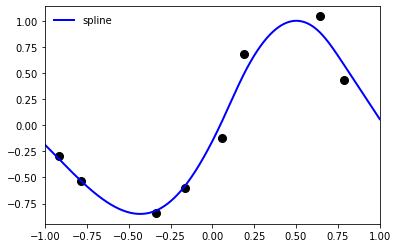

In [20]:
# %%
# fit spline regression with g(0) and regularizing parameter lambda (lambReg)
# as in the paper including an adjustment for the scaling of lambReg
# (see https://stats.stackexchange.com/a/430482/261315)
g_Zero = s**2/8/2 
print('g(0)=', g_Zero)
lambReg = float((n_samples*lambda_tildaReg/(2*g_Zero)/n)/(max(x_train)-min(x_train))**3)
lambda_tildaReg_paper=n_samples*lambda_tildaReg
lambda_paperReg=lambda_tildaReg_paper/(2*g_Zero*n)
print("lambda_paperReg:", lambda_paperReg)

splineReg = splineFit(x_train, y_trainNoise, lambReg)


# %%
# visualize result

radPlot = 1
xPlot = np.linspace(-radPlot, radPlot, 1920)
ySplineReg = splinePredict(splineReg, xPlot)
# yminPlot = min(np.min(model.predict(xPlot)),
#                np.min(modelRidge.predict(xPlot)))-0.05
# ymaxPlot = max(np.max(model.predict(xPlot)),
#                np.max(modelRidge.predict(xPlot)))+0.05

plt.plot(x_train, y_trainNoise, 'ko', markersize=8) 
#plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
#plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=3,
#        color=(1, 5/8, 0.0), label='ridge RSN')
plt.plot(xPlot, ySplineReg, 'b-', linewidth=2, label='spline')

#plt.ylim(-1.125, 1.125)
plt.xlim(-radPlot, radPlot)

plt.legend(loc='upper left', frameon=False) 

60/60 [==============================] - 0s 1ms/step


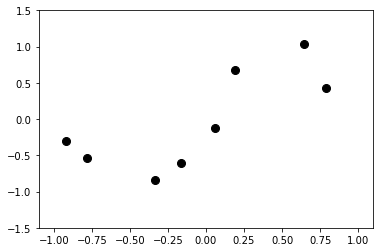

60/60 [==============================] - 0s 1ms/step


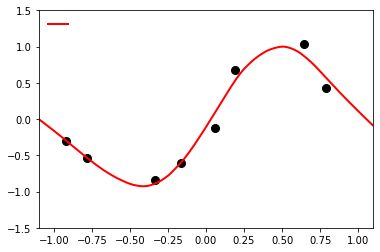

60/60 [==============================] - 0s 1ms/step


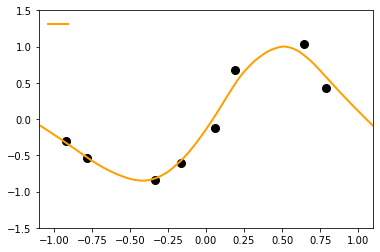

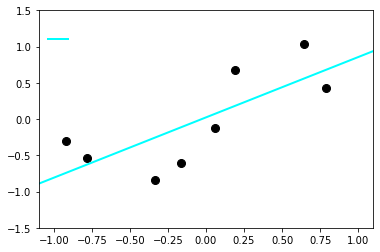

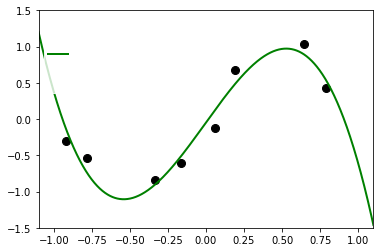

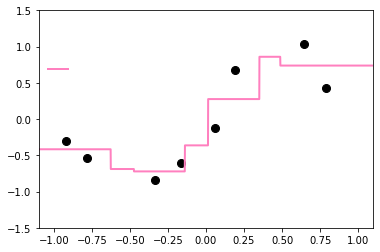

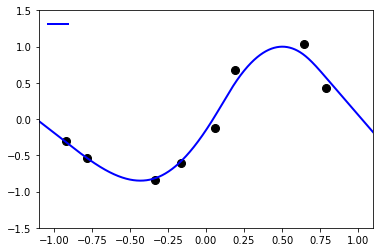

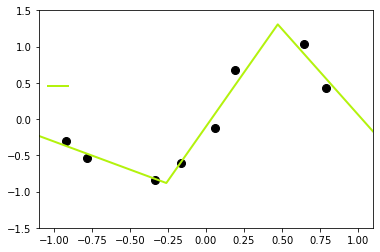

60/60 [==============================] - 0s 1ms/step


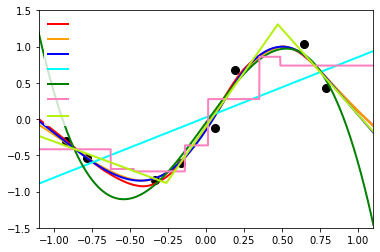

In [21]:
radPlot=1.1
xPlot=np.linspace(-radPlot,radPlot,1920)
y_linReg=linmodelReg.predict(xPlot.reshape(-1, 1))
ySplineReg = splinePredict(splineReg, xPlot)
y_neighReg=neighReg.predict(xPlot.reshape(-1, 1))
y_polyReg=polymodelReg.predict(xPlot.reshape(-1, 1))
y_NNReg=modelReg.predict(xPlot.reshape(-1, 1))
yminPlot=-1.5 #+0*( min(np.min(model.predict(xPlot)),np.min(modelRidge.predict(xPlot)))-0.05 )
ymaxPlot=1.5 #+ 0*( max(np.max(model.predict(xPlot)),np.max(modelRidge.predict(xPlot)))+0.05 )
#choosePlot='spline'

for choosePlot in ['none','RSN', 'RSNridge', 'lin','poly','near','spline','NN','all']:

  #plt.plot(x_train,y_train,'k--',linewidth=1/8)
  plt.plot(x_train,y_trainNoise,'ko',markersize=8)#,label=r'$\left(x_i,y_i \right)$')  # $\left(x_i,y_i \right)$')

  if choosePlot=='RSN' or choosePlot=='all': 
    plt.plot(xPlot,modelRandReg.predict(xPlot),'r-',linewidth=2,label=r'  ')  # $\mathcal{NN}_{\theta^T}$ (implicit)')
  if choosePlot=='RSNridge' or choosePlot=='all': 
    plt.plot(xPlot,modelRidgeRandReg.predict(xPlot),'-',linewidth=2, color=(1, 5/8, 0.0),label=r'      ')  # $\mathcal{NN}_{\theta_{\tilde{\lambda}}}$ (Ridge)')
  #plotFromWeights('modelRidge2097152.h5','/content/modelRidge2097152.h5',T=1024)
  if choosePlot=='spline' or choosePlot=='all':
    #plt.plot(xPlot,ySpline,'-',linewidth=2,label=r'spline', alpha=1.0)  # $f^\lambda$ (spline)')
    plt.plot(xPlot,ySplineReg,'b-', linewidth=2,label=r'smoothing spline', alpha=1.0)  # $f^\lambda$ (spline)')
  else:
    plt.plot(xPlot,ySplineReg,'b-',linewidth=2,label=r'   ', alpha=0.0)  # $f^\lambda$ (spline)')  
  if choosePlot=='lin' or choosePlot=='all':  
    plt.plot(xPlot,y_linReg,'-',color=(0.0, 1.0, 1.0),linewidth=2,label=r'linear')
  else:
    plt.plot(xPlot,y_linReg,'-',color=(0.0, 1.0, 1.0),linewidth=2,label=r'  ', alpha=0)
  if choosePlot=='poly' or choosePlot=='all':
    plt.plot(xPlot,y_polyReg,'g-',linewidth=2,label=r'polynomial') 
  else:
    plt.plot(xPlot,y_polyReg,'g-',linewidth=2,label=r'   ', alpha=0.0)
  if choosePlot=='near' or choosePlot=='all':
    plt.plot(xPlot,y_neighReg,'-',color=(1.0, 0.5, 0.75),linewidth=2,label=r'nearest neighbor')
  else:
    plt.plot(xPlot,y_neighReg,'-',color=(1.0, 0.5, 0.75),linewidth=2,label=r'   ', alpha=0)
  #new:
  if choosePlot=='NN' or choosePlot=='all':
    plt.plot(xPlot,y_NNReg,'-', color=(0.7, 0.95, 0.05), linewidth=2,label=r'$\mathcal{NN}$') 
  else:
    plt.plot(xPlot,y_NNReg,'-', color=(1.0, 0.5, 0.75), linewidth=2,label=r'   ', alpha=0.0) 

  plt.ylim(yminPlot,ymaxPlot)
  plt.xlim(-radPlot,radPlot)

  legend=plt.legend(loc='upper left', frameon=True, framealpha=0.8, edgecolor='1.0')  #, bbox_to_anchor=(0.79, 0.8))
  plt.setp(legend.get_texts(), alpha=0.0)
  plt.savefig('Reg2DifferentModels_'+choosePlot+'.svg', format='svg',transparent=True)
  plt.savefig('Reg2DifferentModels_'+choosePlot+'.pdf', format='pdf',transparent=True)
  plt.show()

In [22]:
stop

NameError: name 'stop' is not defined

In [ ]:
# %%
# visualize result

radPlot = 2
xPlot = np.linspace(-radPlot, radPlot, 1920)
ySpline = splinePredict(spline, xPlot)
yminPlot = min(np.min(model.predict(xPlot)),
               np.min(modelRidge.predict(xPlot)))-0.05
ymaxPlot = max(np.max(model.predict(xPlot)),
               np.max(modelRidge.predict(xPlot)))+0.05
  
plt.plot(x_train, y_train, 'ko', markersize=8) 
plt.plot(xPlot, model.predict(xPlot), 'r-', linewidth=3, label='time-T RSN')
plt.plot(xPlot, modelRidge.predict(xPlot), '-', linewidth=3,
         color=(1, 5/8, 0.0), label='ridge RSN')
plt.plot(xPlot, ySpline, 'b-', linewidth=2, label='spline')
  
plt.ylim(0.4, 0.6)
plt.xlim(-radPlot, radPlot)
 
plt.legend(loc='upper left', frameon=False)
plt.savefig('grownUpVersion.svg', format='svg',transparent=True)